# [Probabilistic Discovery of Time Series Motifs](https://www.cs.ucr.edu/~eamonn/SIGKDD_Motif.pdf)

This paper introduces a time and space efficient approach to find the `top k` approximate repeating `motifs` in time series data.

What are [time series motif's](../concepts/time-series/time_series_motifs.ipynb)?

They're repeatable patterns in a time series (`T`). The brute force way to find them would be to look at all subsequences (`C`) of length `n`, and determine if they're <em>similar</em> (a `match`) to any other subsequence of the same length (under some distance measure `D`). Since we don't know the size of `n` upfront, the search space for this is <em>large</em>, so we'll need to find a way to limit it. 

In order for us to consider two subsequences to be similar, the similarity can't be `trivial`. For example, if we have a sliding window from `x -> x+m`, then the sliding window from `x+1 -> x+m+1` would be pretty similar — we want to ignore these scenarios.

To avoid comparing time series with different offsets and amplitures, we normalize them to have mean 0, and a standard deviation of 1. 

I'll use a worked example to explain the author's implementation, and will start by generating some data.

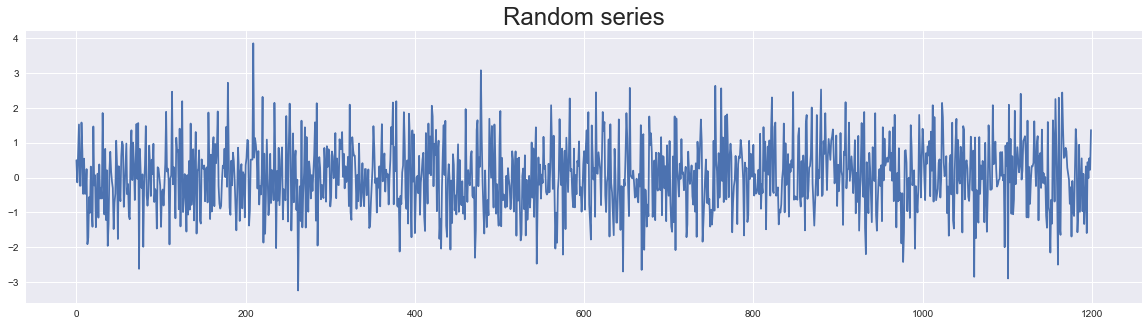

In [689]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')
%matplotlib inline

n_samples, window_size, n_segments, n_symbols = 1200, 6, 200 // 6, 8
rng = np.random.RandomState(42)
X = rng.randn(n_samples)

plt.figure(figsize=(20, 5))
plt.title("Random series", fontsize=24)
plt.plot(X);

I'll implant <strong>3</strong> instances of the same `motif` by replacing data in different locations

motif location: 0 to 125
motif location: 400 to 525
motif location: 800 to 925


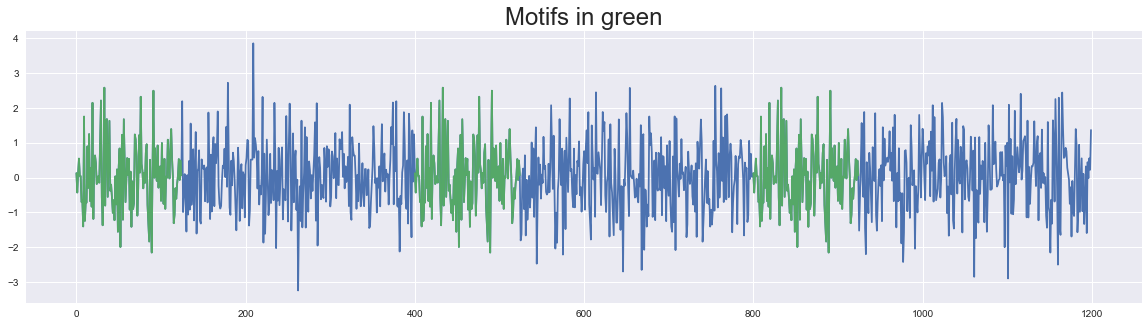

In [690]:
motif_size, n_motifs = 125, 3
motif = rng.randn(motif_size)

point = n_samples // n_motifs
motifs = np.zeros(X.shape[0])
motifs[:] = np.nan

motif_starts = []
for i in range(n_motifs):
    motifs[i*point: i*point + motif_size] = motif
    X[i*point: i*point + motif_size] = motif
    print(f"motif location: {i*point} to {i*point + motif_size}")
    
    motif_starts.append(i*point)

plt.figure(figsize=(20, 5))
plt.plot(X)
plt.plot(motifs)
plt.title("Motifs in green", fontsize=24);

## Implanted motifs
Let's first try to discover the motif when we know `w` — the length of our sliding window.

In [691]:
# I'm keeping variables consistent with the paper for clarity
T, m, n = X, len(X), motif_size

#### Clustering Approach

We could try a clustering algo, but we won't be able to account for `trivial matches`, and it will be biased toward simpler shapes. 

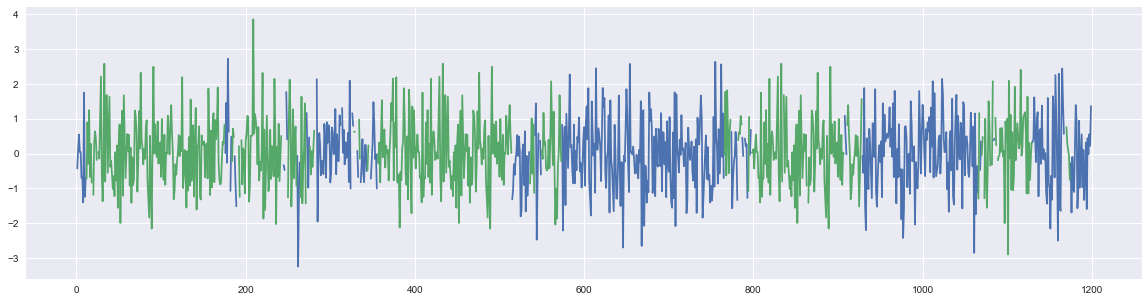

In [692]:
from sklearn.cluster import KMeans

k = 2
model = KMeans(k)

model.fit(S)
labels = model.predict(S)
data_labels = np.ravel([[l] * n for l in labels])

votes = np.zeros((m, k))
i = 0

for l in labels:
    j = i + n
    votes[i:j, l] += 1
    i += 1

final_votes = np.argmax(votes, axis=1)

mat = np.zeros((len(T), k))
for g in range(k):
    orig = T.copy()
    orig[np.where(final_votes != g)] = np.nan
    mat[:, g] = orig.reshape(1, -1)

fig = plt.figure(figsize=(20, 5))
for g in range(k):
    plt.plot(mat[:, g]);

This approach is biased to find matches between subsequences that are next to each other. It doesn't account for trivial matches. 

#### Brute Force Approach
Would require a quadratic number of comparisons. 

In [693]:
# T, m, n = T.reshape(-1, 1), len(T), 100
T, m, n = X, len(X), 125
scaler = StandardScaler()

R = 50
motifs = []
for i in range(m - n + 1):
    for j in range(i+n,  m - n + 1):
        c1 = T[i:i+n]
        c2 = T[j:j+n]
        
        dist = np.linalg.norm(c1 - c2)        

        if dist < 0.03:
            print(dist, i,  i+n, "to", j, j+n)
            motifs.append((i, j))
            
print(f"number of motifs found: {len(motifs)}")

0.0 0 125 to 400 525
0.0 0 125 to 800 925
0.0 400 525 to 800 925
number of motifs found: 3


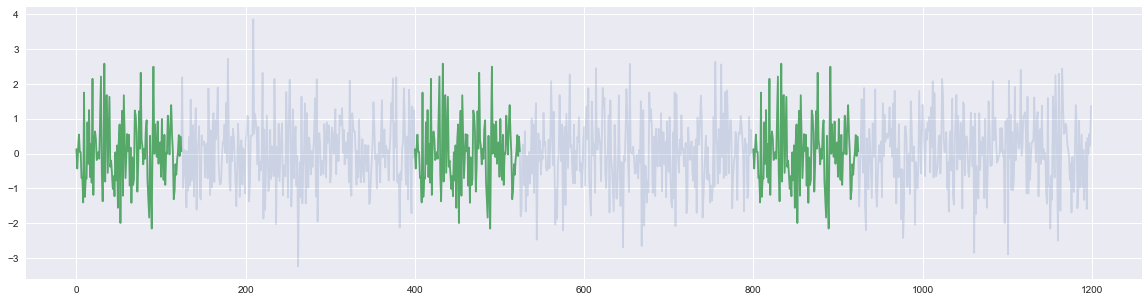

In [694]:
plt.figure(figsize=(20, 5))

plt.plot(T, alpha=0.2)

empty = np.zeros(m)
empty[:] = np.nan

for i, j in motifs:
    empty[i:i+n] = T[i:i+n]
    empty[j:j+n] = T[j:j+n]
    
plt.plot(empty);

As expected, the brute force approach was easily able to find the `motifs`. However, this would be too expensive of an approach for larger data sets.

---

## Adapting random projection to time series data
The author's are taking an approach borrowed from the study of biosequences, and are trying to apply it to time series data. The first steps to do this is to find a  `discrete representation` of their data set. 

### Symbolizing Time Series
#### Using Piecewise Aggregation Approximation 
We're going to treat a time series $C$ of length `n` as a vector where, where we reduce the `n` dimensions to `w` by splitting it up into equally sized frames.

$\bar{C_i} = \frac{w}{n} \sum_{j=\frac{n}{w}(i-1)+1}^{\frac{n}{w}i} c_j$

Below is my implementation

In [660]:
def paa(X, n_segments, plot=False):
    """
    piecewise aggregate approximation 
    """
    n = X.shape[0]
    w = n_segments
    window_size = n // w
    # output with be of size w
    reduced = np.zeros((w, 1))

    # the next 3 lines are all that matter
    for i in range(1, w+1):
        j, k = (n//w) * (i - 1), (n//w) * i 
        reduced[i-1] = (w/n) * np.sum(X[j:k]) 
    
    # this part is just for plotting pursposes    

    inv = np.zeros((X.shape[0]))
    inv[:] = np.nan
    for i in range(len(reduced)):
        inv[i*window_size:(i+1)*window_size] = reduced[i]
    if plot:
        plt.figure(figsize=(24, 12))
        plt.plot(X, alpha=0.1)
        plt.plot(inv);
        plt.title(f"Piecewise Aggregate Approximation with {n_segments} segments", fontsize=24)
        plt.show()
    
    return reduced, inv

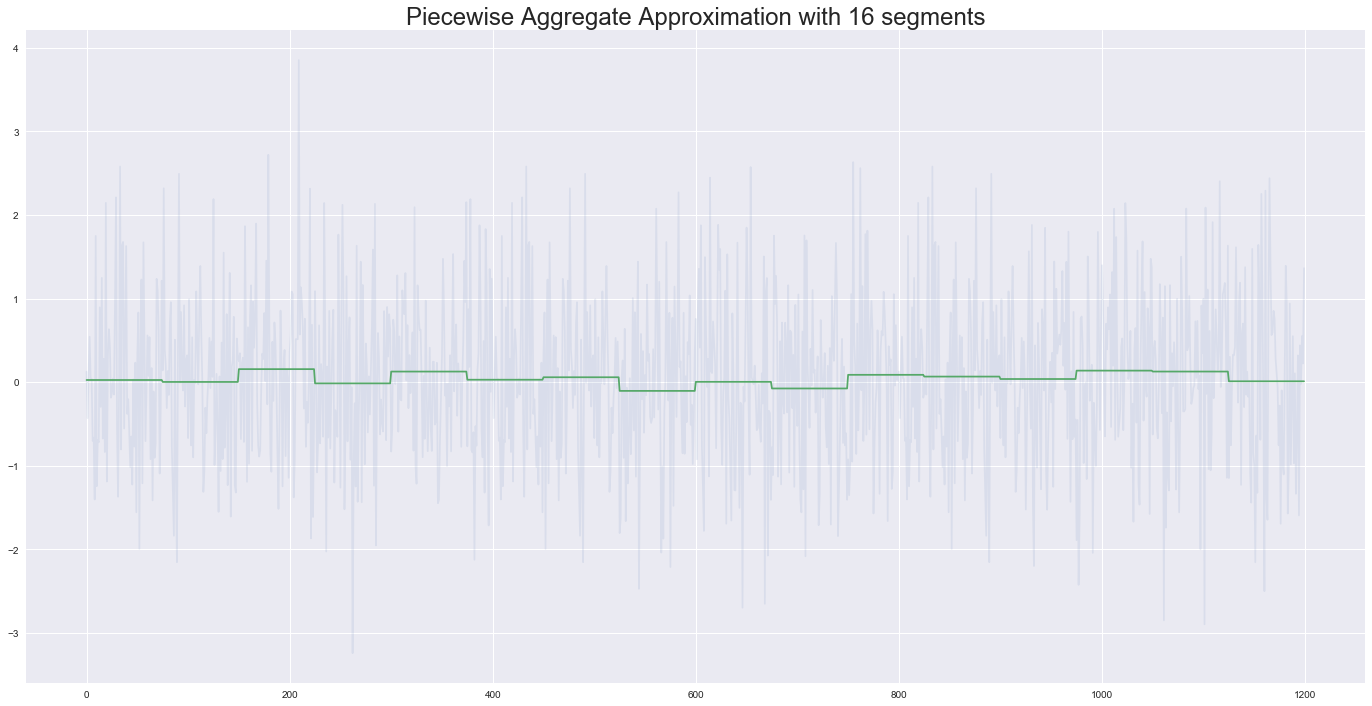

In [695]:
X_paa, inv = paa(X, 16, True)

Now that we have a `PAA` representation of the time series, we can apply further transformation to discretize it. We want to do this in such a way that we will get equiprobable `symbols` — we're just grouping the `PAA` points, and determining the `breakpoints` that would produce equalized areas under a Gaussian curve.

As a sanity check I'm going to compare my solution to the `tslearn` package.

In [696]:
from tslearn.piecewise import PiecewiseAggregateApproximation

total_d, debug = 0, False
for segments in range(5, 30):
    paaObj = PiecewiseAggregateApproximation(n_segments=segments)
    theirs = paaObj.fit_transform(T).reshape(-1, 1)
    mine, _ = paa(T, segments, False)
    assert len(theirs) == len(mine)

    d = np.linalg.norm(mine - theirs)
    total_d += d
    
    if debug:
        print(f"n_segment: {segments}, distance: {d:0.3f}")
    
print(f"total distance: {total_d:0.2f}")

total distance: 0.05


#### SAX implementation

In [697]:
import scipy.stats as st
import string 
import itertools
from tslearn.piecewise import PiecewiseAggregateApproximation

def sax(X, n_segments, n_symbols, debug=False, plot=False):
    """
    symbolic aggregate approximation
    """
    w = n_segments
    a = n_symbols

    ### if you want to use pre built packages you can use tslearn
    #PAA = PiecewiseAggregateApproximation(n_segments=n_segments)
    #X_paa = PAA.fit_transform(X)
    #X_paa_inv = PAA.inverse_transform(X_paa)[0]

    X_paa, X_paa_inv = paa(X, n_segments)
    X_paa_inv = X_paa_inv.reshape(-1, 1)
    
    #  discretize {num_groups} to {n_symbols}
    regions = [float(x) / n_symbols for x in range(1, n_symbols)]
    break_points = st.norm.ppf(regions, scale=1.) # percent point function
        
    letters = np.fromiter(string.ascii_lowercase, dtype=('<U2'))
    symbols = np.argmax(break_points >= X_paa, axis=1)
    
    if debug:
        symbols = letters[np.argmax(break_points >= X_paa, axis=1)]

        print(f"regions: {regions}\n")
        print(f"break point: {break_points}\n") 
        print(f"input: \n")
        for x, s in zip(X, symbols):
            print(s, x, x <= break_points, np.argmax(x <= break_points))
   
    if plot:
        inv_symbols = letters[np.argmax(break_points >= X_paa_inv, axis=1)]
        plt.figure(figsize=(24, 12))
        plt.plot(X, alpha=0.1, label="original")
        plt.plot(X_paa_inv ,alpha=0.5, label="paa")

        idx_symbols = sorted(zip(np.arange(len(inv_symbols)), inv_symbols), key=lambda x: x[1])

        for key, group in itertools.groupby(idx_symbols, lambda x: x[1]):
            empty_symbols = np.zeros(X.shape[0])
            empty_symbols[:] = np.nan
            idx = np.fromiter(map(lambda x: x[0], group), dtype=np.int)
            empty_symbols[idx.ravel()] = X_paa_inv[idx.ravel()].ravel()
            plt.plot(empty_symbols, label="sax " + str(key))

        plt.title(f"SAX with {n_symbols} symbols", fontsize=24)
        plt.legend(prop={'size': 18});
        
    return X_paa, symbols

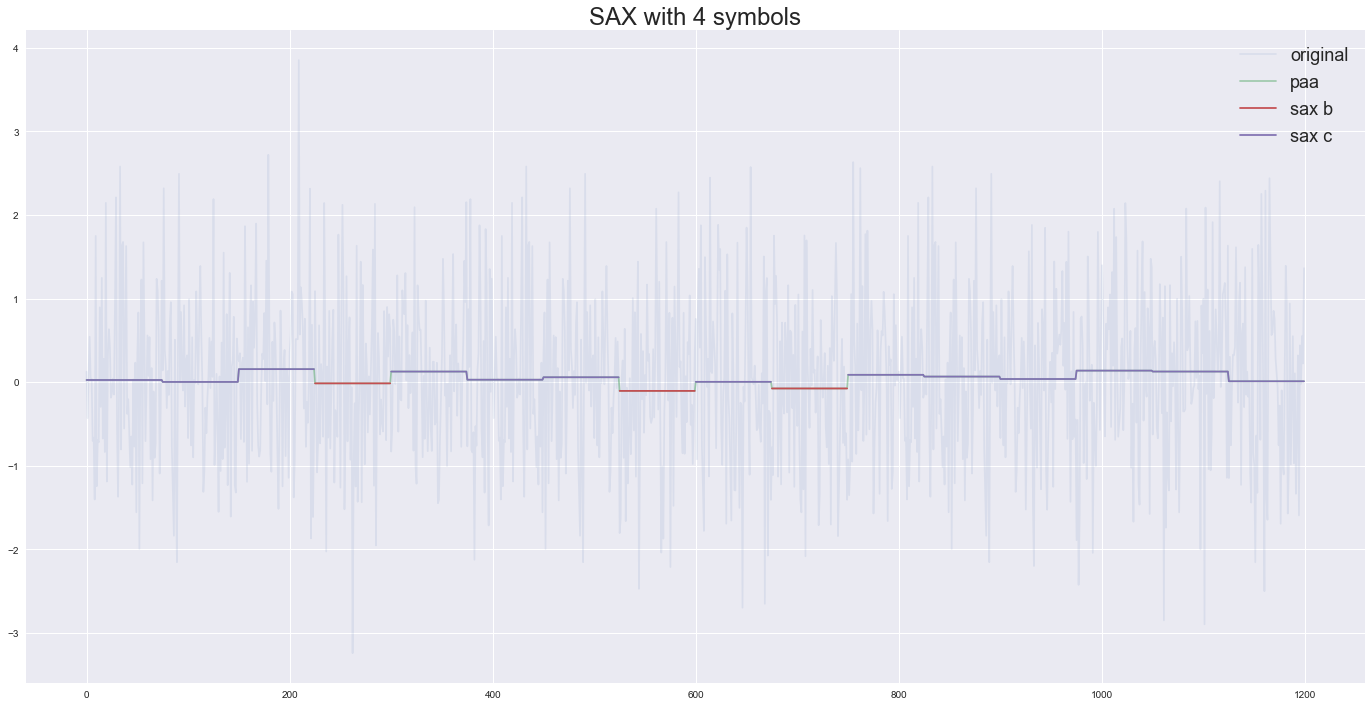

In [698]:
symbols = sax(X, 16, 4, False, True)

At this point we've reduced discretized and reduced the dimensionality of the problem significantly.

As a sanity check I'm going to compare my solution to the `tslearn` package.

In [699]:
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

total_d, debug = 0, False
for segments in range(10, 30):
    for a in range(segments//4, segments//2):
        saxObj = OneD_SymbolicAggregateApproximation(n_segments=segments, alphabet_size_avg=a, alphabet_size_slope=0)
        theirs = saxObj.fit_transform(T)[:, :, 0].ravel()
        _, mine = sax(T, segments, a, False, False)
        
        d = hamming_distance(theirs, mine)
        total_d += d
        if d > 0 and debug:
            print(f"n_segments = {segments}, n_symbols = {a}, distance = {d}")
            print(theirs)
            print(mine)
            
print(f"total distance: {total_d}")

total distance: 20


### Distance Measures
We can compare two time series $C$ and $D$ by using `euclidean distance`:

$D(Q, C) = \sqrt{\sum_{i=1}^n (q_i - c_i)^2}$

By converting the two time series to their `PAA` form, we can find a lower bound approximation:

$DR(\bar{Q}, \bar{C}) = \sqrt{\frac{n}{w}}\sqrt{\sum_{i=1}^w(\bar{q}_i-\bar{c}_i)^2}$

And FINALLY, if we convert use the symbolic representation of the data, we can use the following:

$MINDIST(\hat{Q}, \hat{C}) = \sqrt{\frac{n}{w}}\sqrt{\sum_{i=1}^wdist((\hat{q}_i-\hat{c}_i))^2}$

The authors define `dist()` as a static lookup table that calculates the distance any two categories. 

### Numerosity Reduction
When moving a sliding window over a time series $T$, and using symbolic representations, we don't have to store equivalent symbolic representations that are next to each other. This simple idea can greatly reduce the numerosity. 

### Time Series Projection

In [719]:
import logging

def probabilistic_motifs(T, n, n_segments, a, debug=False):
    """
    T — original time series as numpy array
    n — length of motif
    w — window size for PAA
    """
    # S is of size (elements in time series - length of motif + 1) by (reduced dimensionality)
    S = np.zeros((m-n+1, n_segments)).astype(int)
    collisions = np.zeros((m-n+1, m-n+1))

    # 1) stardize to have mean 0 and std 1 — ignoring for now
    # norm = StandardScaler()
    # norm_T = norm.fit_transform(T.reshape(-1, 1))

    # 2) convert series to symbolic version
    # X_paa, symbols = sax(norm_T, m//w, a, False, False)
    sax_obj = OneD_SymbolicAggregateApproximation(n_segments, a, 1)
    symbols = sax_obj.fit_transform(T)[:, :, 0].ravel()

    for p in range(0, m - n + 1):
        # 1) get sliding window
        C = T[p:p+n]

        # 2) convert subset to symbolic version
        C_symbols = sax_obj.fit_transform(C)[:, :, 0].ravel()

        # 3) assign values to S matrix
        S[p, :] = C_symbols

    # 4) random projection 
    
    # the paper does not do a good job at exlaining their `hash` implementation
    def h(x): return hash(x) % (m - n + 1)
    def update_collisions(x):
        row = h(str(x[0]))
        col = h(str(x[1]))
        collisions[row, col] += 1

    indices = list(range(n_segments))
    # randomly choose two columns to act as a "mask"
    for _ in range(100):
        
        np.random.shuffle(indices)
        random_cols = indices[:2]

        for x in S[:, random_cols]:
            update_collisions(x)

    if debug:
        for k, v in itertools.groupby(sorted(symbols)):
            print(f"symbol: {k}, count: {len(list(v))}")
            
        print(f"collision size: {collisions.shape}, collision count: {np.sum(collisions)}")
    
    row_idx = np.where(np.sum(collisions, axis=1) > 0)
    r, cols = np.where(np.sum(collisions[row_idx, :], axis=0) > 0)

    row_dict = dict(zip(range(len(row_idx[0])), row_idx[0]))
    rows = [row_dict[i] for i in r]

    indices = set([])

    for r, c in zip(rows, cols):
        #if r != c:
        element = (r, c, collisions[r, c])

        if r in motif_starts or c in motif_starts:
            print (n, n_segments, a)
        indices.add(element)

    indices = sorted(set(indices), key=lambda x: x[2], reverse=True)
    return collisions

In [721]:
for n_segments in range(16, 30):
    for a in range(4, 20):
        c = probabilistic_motifs(T, n, n_segments, a)

16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
18 19
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11
19 12
19 13
19 14
19 15
19 16
19 17
19 18
19 19
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
21 4
21 5
21 6
21 7
21 8
21 9
21 10
21 11
21 12
21 13
21 14
21 15
21 16
21 17
21 18
21 19
22 4
22 5
22 6
22 7
22 8
22 9
22 10
22 11
22 12
22 13
22 14
22 15
22 16
22 17
22 18
22 19
23 4
23 5
23 6
23 7
23 8
23 9
23 10
23 11
23 12
23 13
23 14
23 15
23 16
23 17
23 18
23 19
24 4
24 5
24 6
24 7
24 8
24 9
24 10
24 11
24 12
24 13
24 14
24 15
24 16
24 17
24 18
24 19
25 4
25 5
25 6
25 7
25 8
25 9
25 10
25 11
25 12
25 13
25 14
25 15
25 16
25 17
25 18
25 19
26 4
26 5
26 6
26 7
26 8
26 9
26 10
26 11
26 12
26 13
26 14
26 15
26 16
26 17
26 18
26 19
27 4
27 5


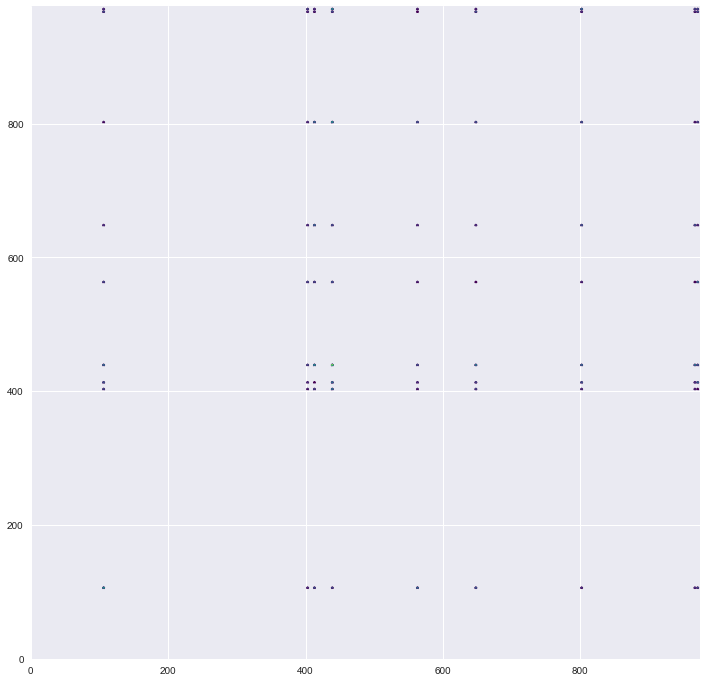

In [707]:
x = y = range(0, collisions.shape[0])
z = collisions
cm = plt.cm.get_cmap('viridis')

plt.figure(figsize=(12, 12))
plt.contour(x, y, z, cmap=cm);

I wasn't able to get the author's exact approach to work properly, but I followed similar approaches [elsewhere](../concepts/time-series/time_series_motifs.ipynb). 

## Other data

In [ ]:
import yfinance as yf 

aapl = yf.download('AAPL', start='2016-01-01')["Close"].values

print(f"number of days: {aapl.shape[0]}")
plt.figure(figsize=(20, 5))
plt.plot(aapl)
plt.title("AAPL daily price from 01/01/2016 to present", fontsize=24)